In [358]:
%pylab inline
import pandas as pd
import seaborn as sns

genes = pd.read_csv('gene_expression_s.csv', index_col=0).sort_index(0).sort_index(1)
sample_data = pd.read_csv('sample_info_qc_pt.csv', index_col=0).sort_index(0).sort_index(1)

GFP = genes.ix['GFP']

sample_data = sample_data.ix[sample_data["Pass QC"]]
sample_data = sample_data.query('cluster != "x"')

genes = genes[sample_data.index]

ercc_idx = filter(lambda i: 'ERCC' in i, genes.index)
egenes = genes.drop(ercc_idx)
egenes = egenes.drop('GFP')
egenes = (egenes / egenes.sum()) * 1e6

egenes = egenes[(egenes > 1).sum(1) > 2]

gene_annotation = pd.read_csv('zv9_gene_annotation.txt', sep='\t', index_col=0)
gene_annotation = gene_annotation.ix[egenes.index]

from ast import literal_eval
sample_data['cluster_color'] = sample_data['cluster_color'].apply(literal_eval)

sample_data['ranktime'] = sample_data['pseudotime'].rank()

logexp = np.log10(egenes + 1)
logexp = logexp[sample_data.index]

Populating the interactive namespace from numpy and matplotlib


In [359]:
import GPy

## Infer a 1-dimensional latent variable over the data

The 1-dimensional variable should ideally correspond to pseudotime / developmental progression.

We use Bayesian GPLVM for this.

The GPLVM will construct a contunous function that takes 1-d real values and maps them in to the gene expression space.

In [360]:
kern = GPy.kern.RBF(1)
m = GPy.models.BayesianGPLVM(logexp.T.as_matrix(), 1, kernel=kern)

In [361]:
m

In [362]:
# This step takes a few minutes
m.optimize(messages=2)

In [363]:
m

In [364]:
sns.set_style('whitegrid')

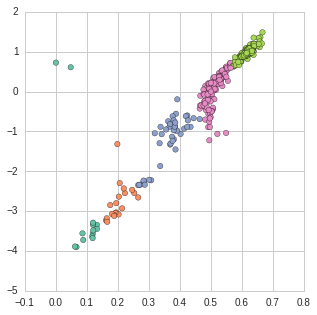

In [365]:
figsize(5, 5)
plt.scatter(sample_data.pseudotime, -m.latent_space_1.mean,
            color=sample_data.cluster_color,
            edgecolor='k',
            s=30);

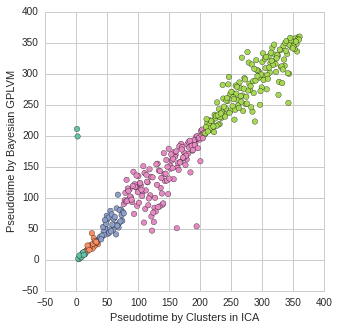

In [366]:
figsize(5, 5)
plt.scatter(sample_data.ranktime, pd.Series(-m.latent_space_1.mean[:,0]).rank(),
            color=sample_data.cluster_color,
            edgecolor='k',
            s=30);
plt.xlabel('Pseudotime by Clusters in ICA');
plt.ylabel('Pseudotime by Bayesian GPLVM');
plt.savefig('cell-reports-rebuttal/alternative-pseudotime-a.pdf')

In [367]:
from scipy import stats

In [369]:
stats.spearmanr(sample_data.ranktime, pd.Series(-m.latent_space_1.mean[:,0]).rank())

(0.96611238848453695, 1.1825136054184554e-212)

## Comparison of the pseudotimes in tSNE space

In addition to the correlation plot above, we can compare how the pseudotimes would map to the tSNE plot by performing regression. Note that this is purely for visualization!

In [387]:
X1 = pd.Series(-m.latent_space_1.mean[:,0]).rank().as_matrix()[:, None]

In [388]:
Y1 = sample_data[['tsne_0']].as_matrix()
Y2 = sample_data[['tsne_1']].as_matrix()

In [389]:
Y_in = np.vstack((Y1, Y2))

In [390]:
X_in = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X1, np.ones_like(X1)))))
ls = 40
kern = GPy.kern.RBF(2, lengthscale=(ls, 1), variance=20, ARD=True)
tsne_reg = GPy.models.GPRegression(X_in, Y_in, kernel=kern)

In [391]:
newX = np.linspace(0,363)[:,None]
newX_0 = np.hstack([newX,np.zeros_like(newX)])
newX_1 = np.hstack([newX,np.ones_like(newX)])

In [392]:
tsne_reg

In [393]:
YY_0_1 = tsne_reg.predict(newX_0)[0]
YY_1_1 = tsne_reg.predict(newX_1)[0]

In [394]:
X2 = sample_data.ranktime.as_matrix()[:, None]
X_in = np.vstack((np.hstack((X2, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X1)))))
kern = GPy.kern.RBF(2, lengthscale=(ls, 1), variance=20, ARD=True)
tsne_reg = GPy.models.GPRegression(X_in, Y_in, kernel=kern)

In [395]:
tsne_reg

In [396]:
YY_0_2 = tsne_reg.predict(newX_0)[0]
YY_1_2 = tsne_reg.predict(newX_1)[0]

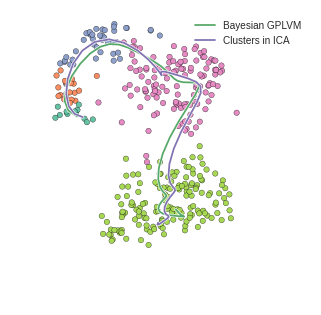

In [398]:
plt.scatter(sample_data.tsne_0, sample_data.tsne_1, color=sample_data.cluster_color, edgecolor='k', s=30);
plt.plot(YY_0_1, YY_1_1, lw=3, c='w');
plt.plot(YY_0_1, YY_1_1, label='Bayesian GPLVM');
plt.plot(YY_0_2, YY_1_2, lw=3, c='w');
plt.plot(YY_0_2, YY_1_2, label='Clusters in ICA');
plt.legend();
plt.xlim(-12, 15);
plt.axis('off');
plt.savefig('cell-reports-rebuttal/alternative-pseudotime-b.pdf')